https://www.youtube.com/watch?v=DbESHcCoWbM&t=13s

In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset
import pytorch_lightning as pl
from PIL import Image
import os
from matplotlib import pyplot as plt

In [2]:
# import sphere data
# define path
# create train and validation and test sets
# 40, 10, 10

# path on my specific device
train_path = "/Users/maryclaremartin/Documents/Github/Research-Fall-2022/cali_camera_data/train"
validation_path = "/Users/maryclaremartin/Documents/Github/Research-Fall-2022/cali_camera_data/validation"
test_path = "/Users/maryclaremartin/Documents/Github/Research-Fall-2022/cali_camera_data/test"

In [3]:
# create image arrays for use in train, validation, and test dataloaders
# path: path to folder on specific device
def image_arrays(path):
    dir_list = os.listdir(path)
    
    # empty array for image names
    image_names = []
    
    # add image names from directory to a list
    for image in dir_list:
        image_names.append(image)

    # sort image titles
    image_names = sorted(image_names)
    
    #create array for images, segmentation images
    images = []
    seg_images = []

    for image in image_names:
        if "img" in image:
            images.append(Image.open(os.path.join(path,image)))
        elif "seg" in image:
            seg_images.append(Image.open(os.path.join(path,image)))
            
    return images, seg_images

In [4]:
# create arrays for train, validation, test
train_images, seg_train_images = image_arrays(train_path)
validation_images, seg_validation_images = image_arrays(validation_path)
test_images, seg_test_images = image_arrays(test_path)

In [5]:
# define dataset
class sphereDataset(Dataset):
    def __init__(self, images, seg_images, transform=transforms.ToTensor(), target_transform=transforms.ToTensor()):
        self.images = images
        self.seg_images = seg_images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.seg_images)

    def __getitem__(self, idx):
        image = self.images[idx]
        seg = self.seg_images[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            seg = self.target_transform(seg)
        return image, seg
    

In [6]:
# array for storing average epoch loss to plot later
avg_loss = []
# store y_score values
y_score_values = []
# store y_true values
y_true_values = []

In [9]:
class ImageClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # 1 by 1 convolution
        self.conv = nn.Conv2d(3,1,(1,1))
        
        self.loss = nn.BCEWithLogitsLoss()
    
    def forward(self, x):
        logits = self.conv(x)
        return logits
    
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=1e-2) 
        return optimizer
    
    def training_step(self, batch, batch_idx):
        x, y = batch

        # forward
        logits = self(x)
        
        # compute the objective function
        J = self.loss(logits, y)
        
        avg_loss.append(J)
            
        return J
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_score_values.append(y_hat)
        y_true_values.append(y)
        # metrics.average_precision_score(y, y_hat)
        return y_hat

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return y_hat
        
    def train_dataloader(self):
        train_data = sphereDataset(train_images, seg_train_images)
        train_loader = DataLoader(train_data, batch_size=1)
        return train_loader
    
    def val_dataloader(self):
        validation_data = sphereDataset(validation_images, seg_validation_images)
        val_loader = DataLoader(validation_data, batch_size=1)
        return val_loader
    
    def test_dataloader(self):
        test_data = sphereDataset(test_images, seg_test_images)
        test_loader = DataLoader(test_data, batch_size=1)
        return test_loader

# initialize model
model = ImageClassifier()
        

In [10]:
trainer = pl.Trainer(max_epochs = 10)
trainer.fit(model)
trainer.test(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type              | Params
-------------------------------------------
0 | conv | Conv2d            | 4     
1 | loss | BCEWithLogitsLoss | 0     
-------------------------------------------
4         Trainable params
0         Non-trainable params
4         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/maryclaremartin/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.
/Users/maryclaremartin/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/maryclaremartin/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trai

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/Users/maryclaremartin/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

[{}]

In [11]:
# compute average loss per epoch and plot
avg_epoch_loss = []
for i in range(10):
    loss_sum = 0
    for j in range(40):
        loss_sum += avg_loss[i*40+j].detach()
    avg_epoch_loss.append(loss_sum/40)

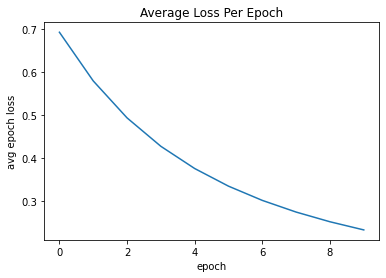

In [12]:
# plot average loss per epcoh
plt.plot(range(10), avg_epoch_loss)
plt.xlabel('epoch')
plt.ylabel('avg epoch loss')
plt.title('Average Loss Per Epoch')
plt.show()

In [ ]:
y_score_values = y_score_values[2:]

In [ ]:
# validation average precision per epoch
# currently crashes program
#for i in range(10):
    #y_score = []
    #y_true = []
    #for j in range(10):
        #y_true.append(y_true_values[i*10+j].detaach().numpy().reshape(-1))
        #y_score.append(y_score_values[i*10+j].detach().numpy().reshape(-1))
        
    #metrics.average_precision_score(y_true, y_score)

print out loss for each epoch (PLOT) for train and validation, print out average precision for validation (PLOT)
By Monday
create validation and test set
overall folder - then train, validation, test
run it on test set